# Current GHG Emissions Situation Analysis

##### by Jingxi
In this notebook, I explored the GHG emissions data and tried to get insight into the distribution and severity of Greenhouse gas emissions. 
The questions mainly includes: 
1. What is the current GHG emissions situations?
2. How does it differ between different building types, zoning, FAR? 


I focused on the Brooklyn and a more specific area. The result will be helpful to predict the GHG emission with action.

In [4]:
import numpy as np
import pandas as pd
import pylab as pl
import os
import geopandas as gpd
import urllib
import requests
import string

from fiona.crs import from_epsg
import pysal as ps
import statsmodels.formula.api as smf
import scipy
import os
import json

pd.set_option('display.max_columns', 500)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1.Data Source

https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/8u86-bviy 


Energy and Water Data Disclosure for Local Law 84 2017 

## 2. GHG Emissions Situation in Brooklyn

### 2.1 Data Cleaning

In [5]:
#data
build_energy_use = pd.read_csv('https://data.cityofnewyork.us/api/views/8u86-bviy/rows.csv?accessType=DOWNLOAD')

In [6]:
build_energy_use.head(1)

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1.013160e+09,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675.0,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447.0,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0.0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...


In [7]:
ghgtotal = build_energy_use[['Order', 'Property Id', 'Property Name', 'Parent Property Id',
       'Parent Property Name', 'BBL - 10 digits',
       'NYC Borough, Block and Lot (BBL) self-reported',
       'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)',
       'Postal Code', 'Street Number', 'Street Name', 'Borough',
       'DOF Gross Floor Area', 'Primary Property Type - Self Selected',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)',
                             'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract']]

In [8]:
ghgtotal.dropna(subset=['Total GHG Emissions (Metric Tons CO2e)'],axis=0,inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
ghgtotal.shape

(11672, 23)

In [10]:
ghgtotal= ghgtotal[ghgtotal['Total GHG Emissions (Metric Tons CO2e)']>0]
ghgtotal.shape

(11564, 23)

In [11]:
bkghgtotal = ghgtotal[ghgtotal.Borough=='Brooklyn']

### 2.2 Data Exploring and Visualization

In [12]:
import shapely

In [13]:
bkghgtotal['longitude'] = bkghgtotal['Longitude'].astype(float)
bkghgtotal['latitude'] = bkghgtotal['Latitude'].astype(float)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [14]:

from fiona.crs import from_epsg

bkghgtotal['lonlat'] = list(zip(bkghgtotal.Longitude,bkghgtotal.Latitude))
bkghgtotal['geometry'] = bkghgtotal[['lonlat']].applymap(lambda x: shapely.geometry.Point(x))
bkghgtotal = gpd.GeoDataFrame(bkghgtotal,geometry='geometry')
bkghgtotal.crs=from_epsg(4326)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
bkghgtotal['Total GHG Emissions (Metric Tons CO2e)'] = bkghgtotal['Total GHG Emissions (Metric Tons CO2e)'].astype(float)

In [16]:
bkghgtotal.rename(columns = {'Total GHG Emissions (Metric Tons CO2e)':'GHG_Total'},inplace=True)

In [17]:
bkghgtotal.reset_index(inplace=True)

In [18]:
nyc = gpd.GeoDataFrame.from_file("/nfshome/jz3309/PUIdata/ZIP_CODE_040114.shp")
bkbasemap = nyc[nyc['PO_NAME']=='Brooklyn']

In [19]:
bkbasemap.to_crs({'init': 'epsg:4326'},inplace=True) 

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame[geo_column_name] = level


In [20]:
zipcode_ghg = bkghgtotal[['Postal Code',
       'GHG_Total']].groupby('Postal Code').mean()

In [21]:
zipcode_ghg.reset_index(inplace=True)

In [22]:
zipcode_ghg.rename(columns={'Postal Code':'ZIPCODE'},inplace=True)

In [23]:
zipcode_ghg.dropna(axis=0,inplace=True)

In [24]:
censusmean = bkbasemap.merge(zipcode_ghg,left_on='ZIPCODE',right_on='ZIPCODE',how='left')

#### Point Distribution and aggregated by census tract

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Text(0.5,1,'Brooklyn GHG emissions condition by census tract(Metric Tons CO2e)')

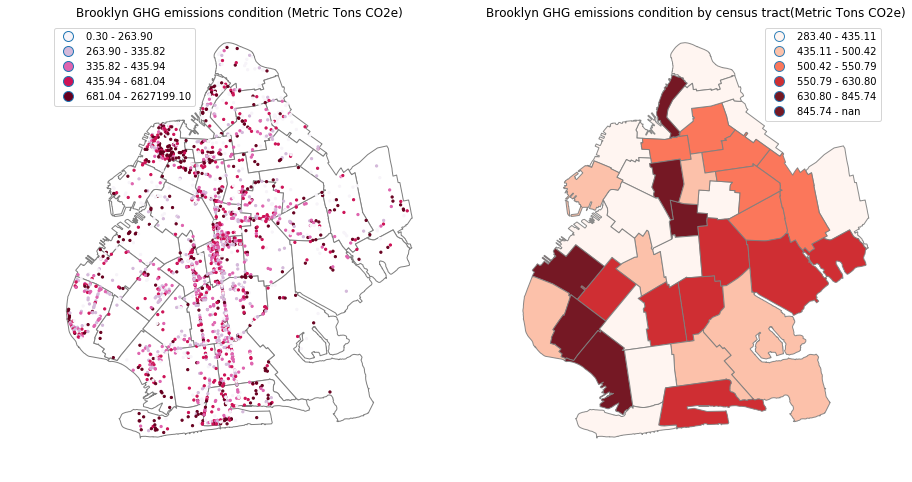

In [25]:
fig = pl.figure(figsize=(15,8)) 
ax = fig.add_subplot(121)
bkbasemap.plot(ax=ax,color='white',edgecolor='grey')
bkghgtotal.plot(column = 'GHG_Total',markersize=5,cmap='PuRd',scheme='quantiles',k=5,legend=True,ax=ax)

ax.axis('off')
ax.set_title('Brooklyn GHG emissions condition (Metric Tons CO2e)')

ax=fig.add_subplot(122)
censusmean.plot(column='GHG_Total',scheme='quantiles',k=6,legend=True,ax=ax,cmap='Reds',edgecolor='grey',alpha=0.9)
ax.axis('off')
ax.set_title('Brooklyn GHG emissions condition by census tract(Metric Tons CO2e)')

Figure1: The plot on the right shows the distribution of GHG emissions in Brooklyn which was colored in terms of emissions. The right plot is the GHG emissions aggregated by mean on a level of census tract. Emissions are higher in coastal areas to the south and east Brooklyn. The red hook area has low emissions of about 440(Metric Tons CO2e). 

#### GHG Emissions Aggregated by Property Use

Text(0,0.5,'GHG Emission (Metric Tons CO2e)')

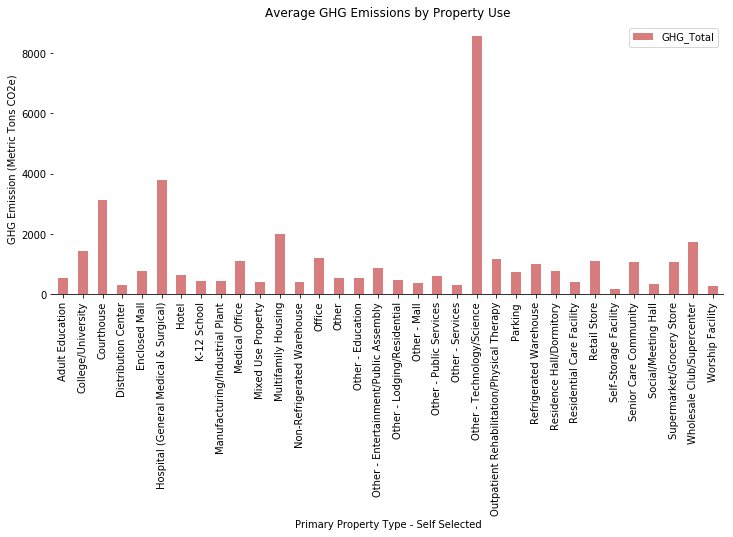

In [26]:
fig = pl.figure(figsize=(12,5)) 
ax = fig.add_subplot(111)

bkghgtotal.groupby('Primary Property Type - Self Selected').mean()[['GHG_Total']].plot(kind='bar',color='IndianRed',ax=ax,alpha=0.8)
ax.set_title('Average GHG Emissions by Property Use')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_ylabel('GHG Emission (Metric Tons CO2e)')

Figure2: The figure above is the average GHG emissions by property use. The property use of technology and science has highest level of ghg emissions while the self-storage facility has the lowest. Thers is a big difference between the highest and lowest values. 

#### GHG Emissions Aggregated by Land Use

In [27]:
plutobk = gpd.gpd.GeoDataFrame.from_file('data/BKPLUTO/plutobk.shp')

In [28]:
plutobk.borough.unique()

array(['QN', 'MN', 'BK'], dtype=object)

In [29]:
plutobk_ = plutobk[plutobk['borough']=='BK']

In [30]:
meanghgbbl = ghgtotal.groupby('BBL - 10 digits').mean()

In [31]:
meanghgbbl.reset_index(inplace=True)

In [32]:
bkmergedghg = plutobk_.merge(meanghgbbl,left_on = 'bbl',right_on='BBL - 10 digits',how='left')[['address', 'bbl', 'borough', 'builtfar', 'landuse', 'yearbuilt',
                                                                                               'Total GHG Emissions (Metric Tons CO2e)']]

In [33]:
#plot ghg emissions by landuse
bkmergedghg['landuse'] = bkmergedghg['landuse'].astype('float')

[Text(0,0,'One &Two Family Buildings'),
 Text(0,0,'Multi-Family Walk-Up Buildings'),
 Text(0,0,'Multi-Family Elevator Buildings'),
 Text(0,0,'Mixed Residential & Commercial Buildings'),
 Text(0,0,'Commercial & Office Buildings'),
 Text(0,0,'Industrial & Manufacturing'),
 Text(0,0,'Transportation & Utility'),
 Text(0,0,'Public Facilities & Institutions'),
 Text(0,0,'Open Space & Outdoor Recreation'),
 Text(0,0,'Parking Facilities'),
 Text(0,0,'Vacant Land')]

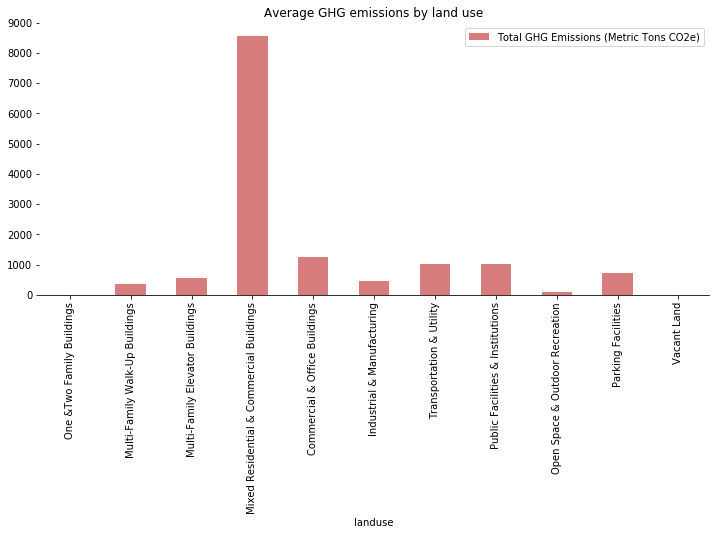

In [34]:
fig = pl.figure(figsize=(12,5)) 
ax = fig.add_subplot(111)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
bkmergedghg.groupby('landuse').mean()[['Total GHG Emissions (Metric Tons CO2e)']].plot(kind='bar',color='IndianRed',ax=ax,alpha=0.8)
ax.set_title('Average GHG emissions by land use')
ax.set_xticklabels(['One &Two Family Buildings','Multi-Family Walk-Up Buildings','Multi-Family Elevator Buildings', 'Mixed Residential & Commercial Buildings',
                    'Commercial & Office Buildings', 'Industrial & Manufacturing', 'Transportation & Utility','Public Facilities & Institutions',
                    'Open Space & Outdoor Recreation','Parking Facilities','Vacant Land'])

Figure3:  The figure above is the average GHG emissions by land use. The Mixed Residential & Commercial Buildings has highest level of ghg emissions while the land use of One&Two Familiy Buildings has the lowest. 

#### GHG Emissions Aggregated by FAR

In [35]:
farghg = bkmergedghg[bkmergedghg['Total GHG Emissions (Metric Tons CO2e)']<500000]
farghg.dropna(subset=['Total GHG Emissions (Metric Tons CO2e)'],inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [36]:
#GHG EMISSIONS VS. BUILT FAR


Text(0.5,1,'GHG Emissions vs Built FAR')

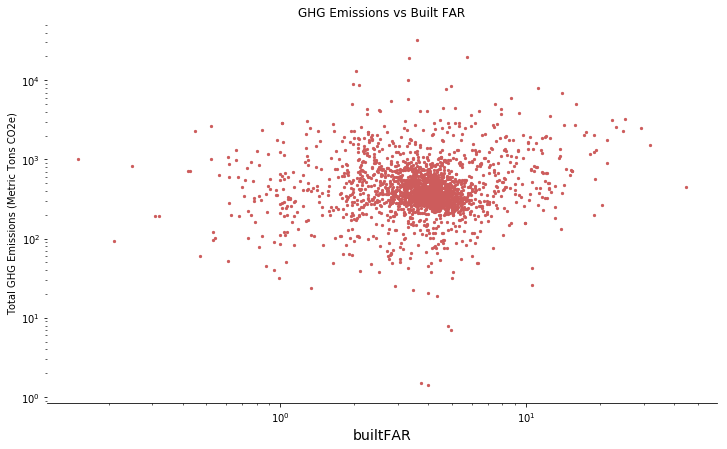

In [37]:
#log scale

fig = pl.figure(figsize=(12,7)) 
ax = fig.add_subplot(111)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
#ax.scatter(farghg['builtfar'],farghg['Total GHG Emissions (Metric Tons CO2e)'],color='IndianRed')

farghg.plot(x='builtfar',y='Total GHG Emissions (Metric Tons CO2e)', loglog=True, marker='.',kind='scatter',color='IndianRed',ax=ax)
ax.set_xlabel('builtFAR',fontsize=14)
ax.set_title('GHG Emissions vs Built FAR')

Figure4: Figure above shows the GHG emissions verses built FAR in a log space which show the correlation between the two variables more clearly. There might be a positive relationship between them.

In [38]:
farghg.head()

,address,bbl,borough,builtfar,landuse,yearbuilt,Total GHG Emissions (Metric Tons CO2e)
8,77 LIVINGSTON STREET,3.002660e+09,BK,10.49,3.0,1964,738.2
197,921 MONTGOMERY STREET,3.014190e+09,BK,4.39,3.0,1927,447.5
1169,1483 SHORE PARKWAY,3.064890e+09,BK,2.09,3.0,1949,1808.6
1727,45 FALMOUTH STREET,3.087450e+09,BK,2.64,3.0,1939,284.0
1784,230 ASHLAND PLACE,3.020958e+09,BK,10.98,4.0,2006,1604.4


In [39]:
farghg.rename(columns={'Total GHG Emissions (Metric Tons CO2e)': 'ghgtotal'},inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [40]:
farghg2 = farghg

In [41]:
farghg2['logghg'] = np.log10(farghg2['ghgtotal'])
farghg2['logfar'] = np.log10(farghg2['builtfar'])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [42]:
log10(1.8)

0.25527250510330607

In [43]:
log10(2.8)

0.44715803134221921

In [44]:
farghg2.dtypes

address       object
bbl          float64
borough       object
builtfar     float64
landuse      float64
yearbuilt      int64
ghgtotal     float64
logghg       float64
logfar       float64
dtype: object

In [45]:
farghg2 = farghg2[farghg2['logghg']> 1]

In [46]:
farghg2 = farghg2[farghg2['logfar']>0]

In [47]:
mod = smf.ols(formula = 'logghg ~ logfar',data = farghg2 ).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logghg   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     16.45
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           5.17e-05
Time:                        11:43:42   Log-Likelihood:                -684.68
No. Observations:                2142   AIC:                             1373.
Df Residuals:                    2140   BIC:                             1385.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.5366      0.023    111.644      0.000         2.492     2.581
logfar         0.1476      0.036      4.056      0.000         0.076     0.219
==============================================================================
Omnibus:                      251.219   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              939.438
Skew:                           0.539   Prob(JB):                    1.01e-204
Kurtosis:                       6.060   Cond. No.                         6.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R^2 is low so there we couldn't  use the far to predict the ghg emissions for the with-action.

In [48]:
#0.1476*0.44715803134221921 + 2.5366

In [49]:
from statsmodels.graphics.api import abline_plot

Text(0.5,1,'GHG emission vs. FAR in log space')

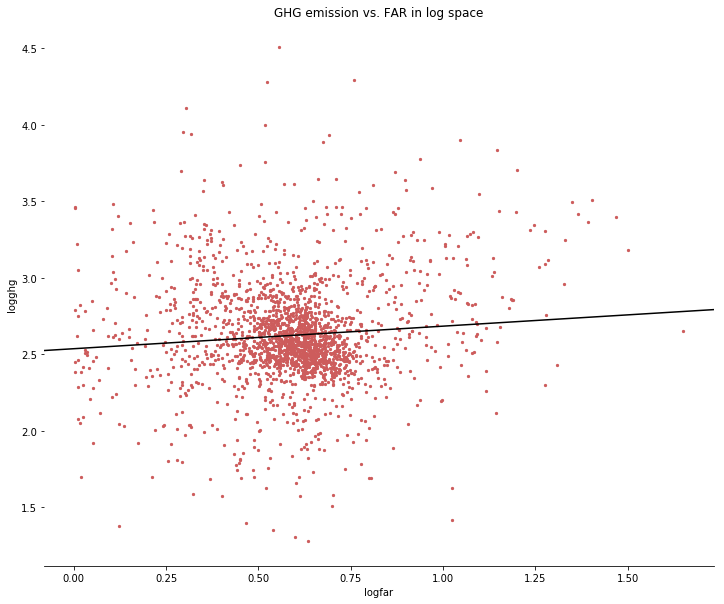

In [50]:
figure, ax = plt.subplots(figsize=(12 ,10))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
farghg2.plot(x='logfar',y='logghg',marker='.',kind='scatter',color='IndianRed',ax=ax)
abline_plot(model_results=mod, ax=ax, color='black')
ax.set_title('GHG emission vs. FAR in log space')

Figure5 : Figure above shows the logGHG Emissions verses log FAR with a fitted line. However, there is not a strong correlation between them so I'm not able to do accurately prediction using the FAR.

## 3. GHG EMISSIONS SITUATION IN STUDY AREA

### 3.1 Define the scope 

In [51]:
from zipfile import ZipFile
zf = ZipFile('data/draw_scope1.zip', 'r')
zf.extractall('data')
zf.close()

In [52]:
basemap = gpd.GeoDataFrame.from_file('data/pluto.shp')

Text(0.5,1,'The study area')

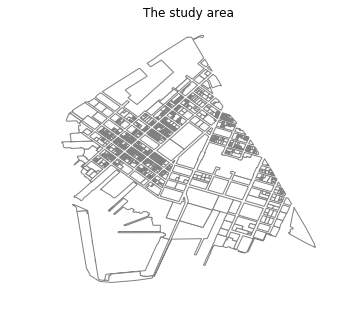

In [104]:
fig = pl.figure(figsize=(5,5)) 
ax = fig.add_subplot(111)
basemap.plot(color='white',edgecolor='grey',ax=ax)
ax.axis('off')
ax.set_title('The study area')

Figure 6: The above is the study area, Red Hook. 

In [54]:
bkghgtotal.dropna(subset=['BBL - 10 digits'],axis=0,inplace=True)

In [55]:
basebbl = basemap[['bbl','zipcode','bldgarea', 'bldgclass', 'block', 'borough',
        'builtfar', 'commfar', 'factryarea', 'landuse',
        'numfloors', 'residfar']]
merge2 = basebbl.merge(bkghgtotal,left_on = 'bbl',right_on='BBL - 10 digits',how='inner')

In [56]:
merge2.shape

(15, 40)

### 3.2 Exploration and Visulization

#### Mean GHG emission by property type, land use and FAR

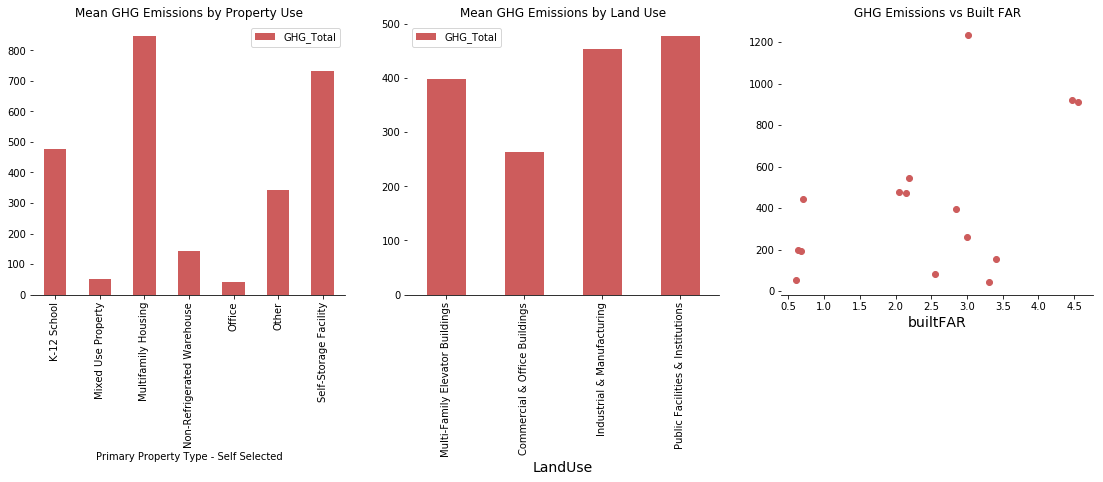

In [57]:
fig = pl.figure(figsize=(19,5)) 


ax = fig.add_subplot(131)
merge2.groupby('Primary Property Type - Self Selected').mean()[['GHG_Total']].plot(kind='bar',color='IndianRed',ax=ax)
ax.set_title('Mean GHG Emissions by Property Use')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax=fig.add_subplot(132)
merge2.groupby('landuse').mean()[['GHG_Total']].plot(kind='bar',color='IndianRed',ax=ax)
ax.set_xlabel('LandUse',fontsize=14)
ax.set_xticklabels( ['Multi-Family Elevator Buildings','Commercial & Office Buildings','Industrial & Manufacturing','Public Facilities & Institutions'])
ax.set_title('Mean GHG Emissions by Land Use')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)


ax=fig.add_subplot(133)
ax.scatter(merge2['builtfar'],merge2['GHG_Total'],color='IndianRed')
ax.set_xlabel('builtFAR',fontsize=14)
ax.set_title('GHG Emissions vs Built FAR')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)



Figure 7 : Figure on the left shows the mean level of GHG emissions by property use. The mutifamily housing has the highest level. The middle plot shows the mean ghg emissions by land use and the public facilities & institutions has the highest value. Since there is only a few points in the study area, it's hard to find the correlation between ghg emissions and built FAR. 

#### Aggreated by BBL and Land Use

In [58]:
basemap['landuse'] = basemap['landuse'].astype(float)

In [59]:
areaghg = gpd.GeoDataFrame(merge2)

In [60]:
bblgroup = merge2.groupby('bbl').mean()[['GHG_Total']]
bblgroup.reset_index(inplace=True)

In [61]:
bblmap = basemap.merge(bblgroup,left_on='bbl',right_on='bbl',how='left')

In [76]:
landusegroup = merge2.groupby('landuse').mean()[['GHG_Total']]
landusegroup.reset_index(inplace=True)
landusegroup['landuse'] = [3.0,5.0,6.0,8.0]
landusegroup.dtypes

landuse      float64
GHG_Total    float64
dtype: object

In [77]:
landusemap = basemap.merge(landusegroup,on='landuse',how='left')

(-74.021131370068886,
 -73.995436575082564,
 40.663591932758727,
 40.687625622401363)

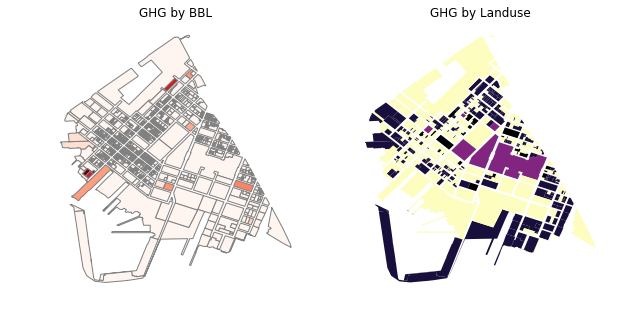

In [78]:
fig = pl.figure(figsize=(10,5)) 

ax = fig.add_subplot(121)
bblmap.plot(column='GHG_Total',cmap='Reds',ax=ax,edgecolor='grey')
ax.axis('off')
ax.set_title('GHG by BBL')


ax = fig.add_subplot(122)
landusemap.plot(column='GHG_Total',cmap='magma_r',edgecolor=None,ax=ax)
ax.set_title('GHG by Landuse')
ax.axis('off')


Figure8: The left side of figure 8 shows the GHG emission by BBL. There are some higher value distributed in the western and northern costal area.The right side figure shows the GHG emissions by land use.

In [82]:
landusegroup['Landeuse_2'] = ['Multi-Family Elevator Buildings','Commercial & Office Buildings','Industrial & Manufacturing','Public Facilities & Institutions']

,landuse,GHG_Total,Landeuse_2
0,3.0,397.90,Multi-Family Elevator Buildings
1,5.0,262.80,Commercial & Office Buildings
2,6.0,453.42,Industrial & Manufacturing
3,8.0,477.70,Public Facilities & Institutions


In [86]:
landusegroup.columns

Index(['landuse', 'GHG_Total', 'Landeuse_2'], dtype='object')

Text(0.5,1,'GHG Emissions by Land Use')

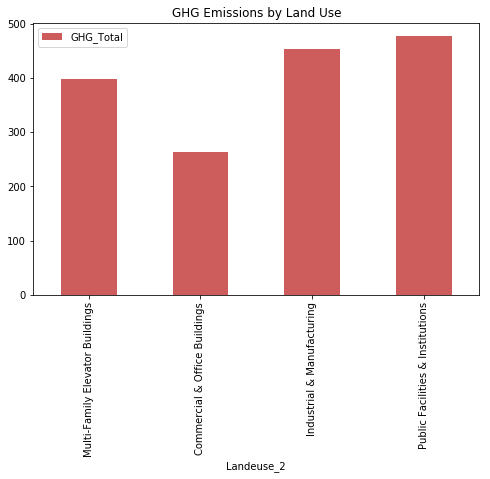

In [103]:
landusegroup.set_index(['Landeuse_2'])[['GHG_Total']].plot(kind='bar',color='IndianRed',figsize=(8,5))
plt.title('GHG Emissions by Land Use')

Figure8: Figure above shows the ghg emission in different land use whitin the study area. The public facilities and Institutions has highest level of emission.

In [105]:
landusegroup

,landuse,GHG_Total,Landeuse_2
0,3.0,397.90,Multi-Family Elevator Buildings
1,5.0,262.80,Commercial & Office Buildings
2,6.0,453.42,Industrial & Manufacturing
3,8.0,477.70,Public Facilities & Institutions


## Conclusion

The Red Hook area has a level of GHG emissions of 397 Metric Tons CO2e which is in a lower level comparing to the mean level of other cences tracts in Brooklyn. However, there is a limitation using the data set form LL84 since the data are from the record reported which doesn't contain each bilding's information. 